In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [4]:
grades_df = pd.read_csv("1D_grades.csv", names=["Grades"])
grades_df.head()

,Grades
0,83
1,76
2,87
3,96
4,89


In [5]:
grades = grades_df.values

In [6]:
def normalize(data):
    mean_data = data.mean()
    std_data = data.std()
    return (data - mean_data) / std_data

In [7]:
grades_normalized = normalize(grades)

print(grades_normalized.mean())
print(grades_normalized.std())

2.220446049250313e-16
1.0


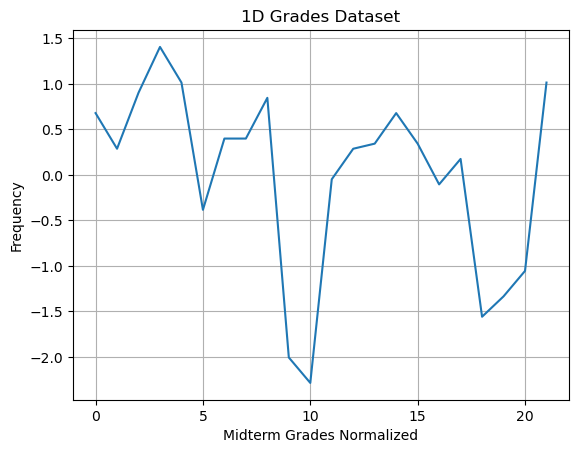

In [188]:
plt.title("1D Grades Dataset")
plt.plot(grades_normalized)
plt.xlabel("Midterm Grades Normalized")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [29]:
synthetic_df = pd.read_csv(
    "2D_synthetic_gaussians.csv", names=["Dimension 1", "Dimension 2"]
)
synthetic_df.head()

,Dimension 1,Dimension 2
0,124.835708,243.086785
1,132.384427,326.151493
2,88.292331,238.293152
3,178.960641,288.371736
4,76.526281,277.128002


In [30]:
synthetic = synthetic_df.values

In [31]:
synthetic_normalized = normalize(synthetic)

print(synthetic_normalized.mean())
print(synthetic_normalized.std())

7.105427357601002e-17
1.0


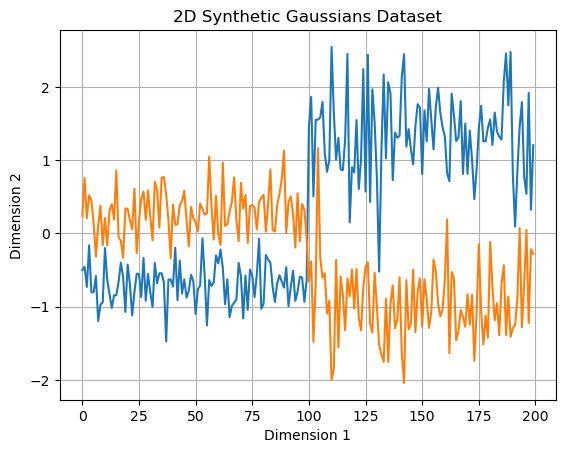

In [192]:
plt.title("2D Synthetic Gaussians Dataset")
plt.plot(synthetic_normalized)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

# Part 2

## Histograms

In [193]:
bandwidths = [0.1, 0.3, 0.5, 0.7]

### 1D Grades Dataset

In [194]:
def histogram_pdf(data, bandwidth):
    min_value = data.min()
    max_value = data.max()
    bins = np.arange(min_value - bandwidth, max_value + bandwidth, bandwidth)
    hist = np.zeros(len(bins) - 1)

    for i in range(len(bins) - 1):
        hist[i] = ((data >= bins[i]) & (data < bins[i + 1])).sum()

    hist /= len(data) * bandwidth

    return hist, bins

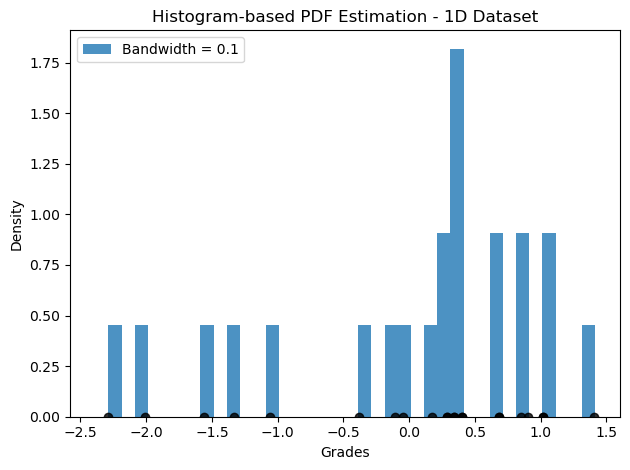

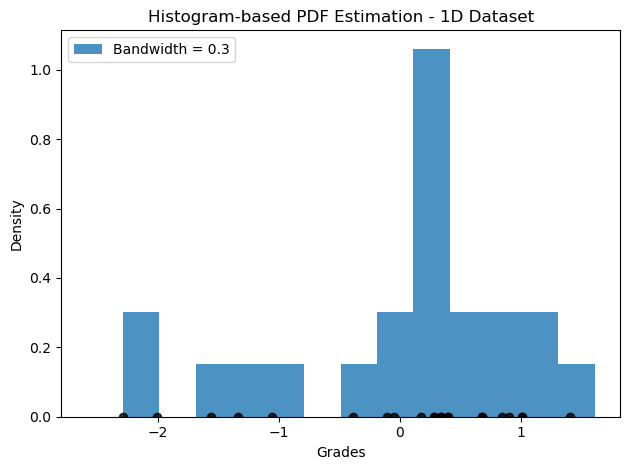

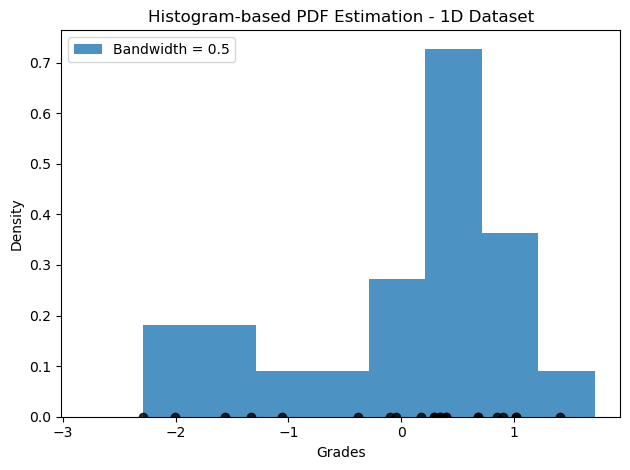

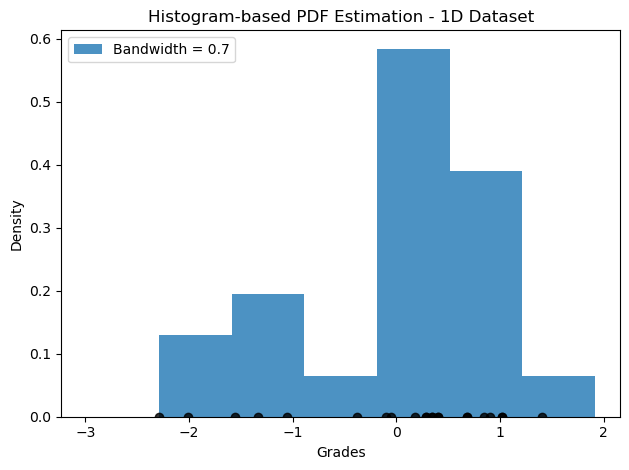

In [195]:
for bandwidth in bandwidths:
    hist, bins = histogram_pdf(grades_normalized, bandwidth)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.bar(
        bin_centers, hist, width=bandwidth, alpha=0.8, label=f"Bandwidth = {bandwidth}"
    )
    plt.scatter(
        grades_normalized, np.zeros(len(grades_normalized)), color="black", alpha=0.8
    )

    plt.title("Histogram-based PDF Estimation - 1D Dataset")
    plt.xlabel("Grades")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 2D Synthetic Gaussians Dataset

In [196]:
def histogram_2d_pdf(data, bandwidth):
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()

    x_bins = np.arange(x_min, x_max + bandwidth, bandwidth)
    y_bins = np.arange(y_min, y_max + bandwidth, bandwidth)

    hist = np.zeros((len(x_bins) - 1, len(y_bins) - 1))

    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            hist[i, j] = (
                (data[:, 0] >= x_bins[i])
                & (data[:, 0] < x_bins[i + 1])
                & (data[:, 1] >= y_bins[j])
                & (data[:, 1] < y_bins[j + 1])
            ).sum()

    hist /= len(data) * bandwidth * bandwidth

    return hist, x_bins, y_bins

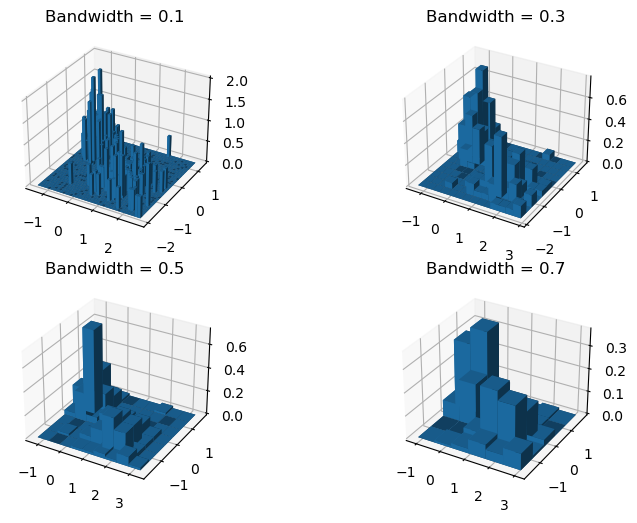

In [197]:
fig = plt.figure(figsize=(9, 6))
for i, bandwidth in enumerate(bandwidths, 1):
    hist, x_bins, y_bins = histogram_2d_pdf(synthetic_normalized, bandwidth)

    x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2

    ax = fig.add_subplot(2, 2, i, projection="3d")
    ax.bar3d(
        x_bin_centers.repeat(len(y_bin_centers)),
        np.tile(y_bin_centers, len(x_bin_centers)),
        np.zeros_like(hist).ravel(),
        bandwidth,
        bandwidth,
        hist.ravel(),
        shade=True,
    )
    ax.set_title(f"Bandwidth = {bandwidth}")

plt.show()

# 3.2 Kernels

In [198]:
def parzenWindowd(u, *args):
    if np.abs(u) <= np.abs(1 / 2):
        return 1
    else:
        return 0


def gaussian(u, sigma):
    return (1 / (math.sqrt(2 * math.pi) * sigma)) * math.exp(
        -(u**2) / (2 * sigma**2)
    )


def kernel(kernelFunction, dataPoint, x, h, sigma):
    dim = len(dataPoint)
    prod = 1
    for j in range(0, dim):
        prod *= kernelFunction((x[j] - dataPoint[j]) / h, sigma)
    return prod


def kernel1d(kernelFunction, dataPoint, x, h, sigma):
    dim = len(dataPoint)
    prod = 1
    for j in range(0, dim):
        prod *= kernelFunction((x - dataPoint) / h, sigma)
    return prod


def KDE1D(data_1d, h, X_1d, sigma, kernel_type="gaussian"):
    N = np.size(X_1d, 0)
    d = np.size(data_1d, 1)
    probs = []

    if kernel_type == "parzen":
        K = parzenWindowd
    elif kernel_type == "gaussian":
        K = gaussian

    for x in X_1d:
        px = (
            1
            / N
            * 1
            / (h**d)
            * np.sum([kernel1d(K, dataPoint, x, h, sigma) for dataPoint in data_1d])
        )
        probs.append(px)

    return probs


def KDE(data_2d, h, X_2d, sigma, kernel_type="gaussian"):
    N = np.size(X_2d, 0)
    d = np.size(data_2d, 1)
    probs = []

    if kernel_type == "parzen":
        K = parzenWindowd
    elif kernel_type == "gaussian":
        K = gaussian

    for x in X_2d:
        px = (
            1
            / N
            * 1
            / (h**d)
            * np.sum([kernel(K, dataPoint, x, h, sigma) for dataPoint in data_2d])
        )
        probs.append(px)

    return probs

## Parzen Window

### 1D Grades Dataset

Bandwidth : 0.1
Bandwidth : 0.3
Bandwidth : 0.5
Bandwidth : 0.7


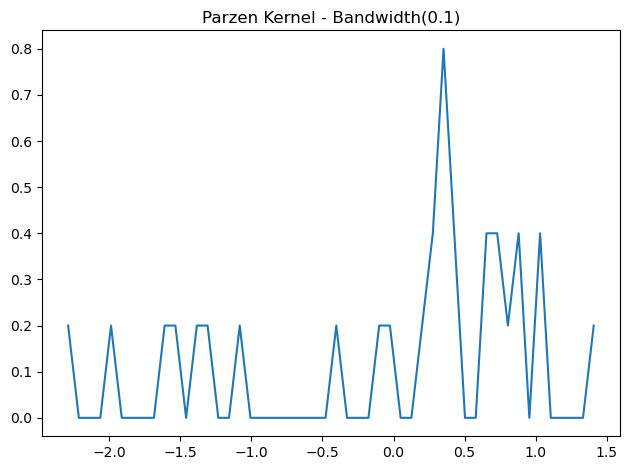

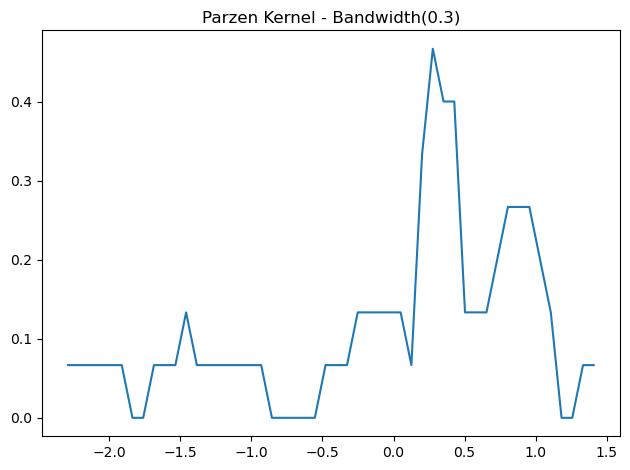

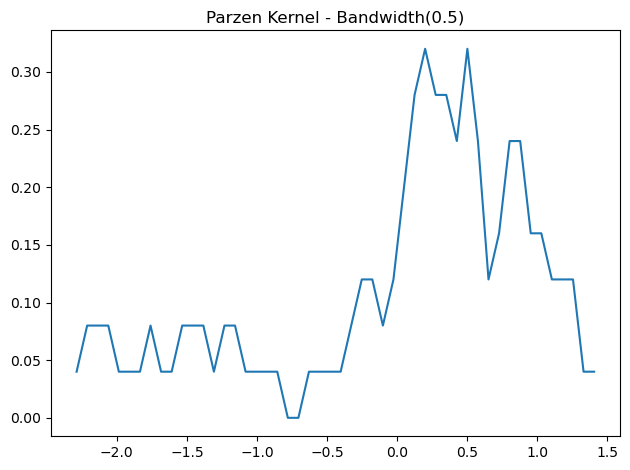

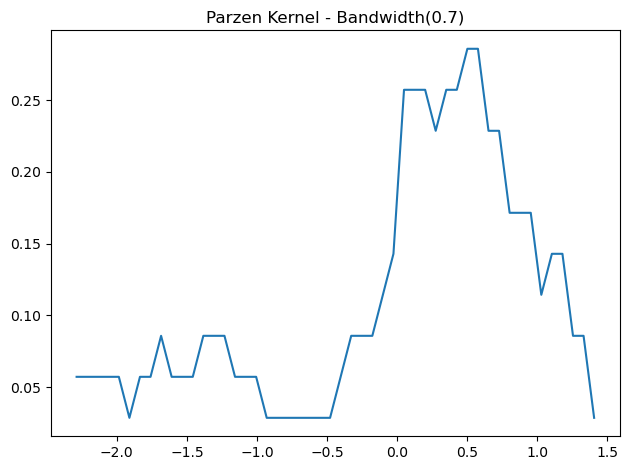

In [199]:
x = np.linspace(np.amin(grades_normalized), np.amax(grades_normalized), 50)

(xx,) = np.meshgrid(x)

X_1d = xx.ravel()
parzenZZs = []



for h in bandwidths:
    print(f"Bandwidth : {h}")

    probs = KDE1D(grades_normalized, h, X_1d, 0, "parzen")

    zz = np.array(probs)

    parzenZZs.append(zz)

for i in range(len(bandwidths)):
    fig, ax = plt.subplots(1)
    ax.plot(x, parzenZZs[i])
    ax.set_title("Parzen Kernel - Bandwidth(" + str(bandwidths[i]) + ")")
    fig.tight_layout()

plt.show()

### 2D Synthetic Gaussians Dataset

Bandwidth : 0.1
Bandwidth : 0.3
Bandwidth : 0.5
Bandwidth : 0.7


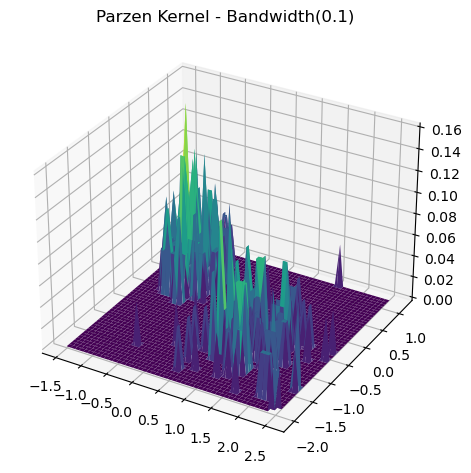

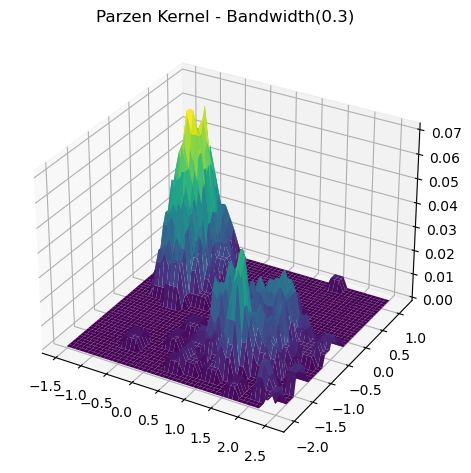

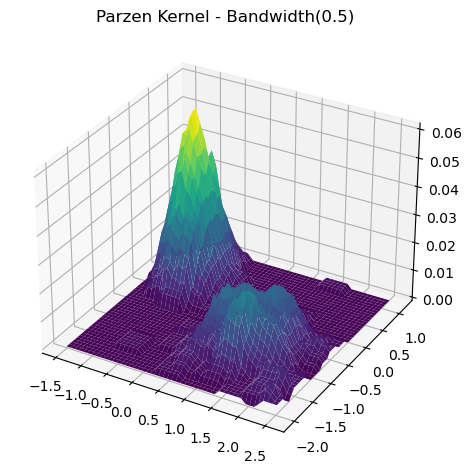

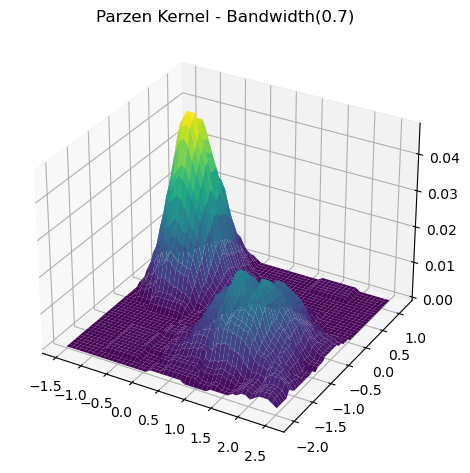

In [200]:
x = np.linspace(
    np.amin(synthetic_normalized[:, 0]), np.amax(synthetic_normalized[:, 0]), 50
).reshape(-1, 1)
y = np.linspace(
    np.amin(synthetic_normalized[:, 1]), np.amax(synthetic_normalized[:, 1]), 50
).reshape(-1, 1)
xx, yy = np.meshgrid(x, y)
X_2d = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)

parzenZZs = []
for h in bandwidths:
    print(f"Bandwidth : {h}")
    probs = KDE(synthetic_normalized, h, X_2d, 0, "parzen")
    zz = np.array(probs).reshape(xx.shape)
    parzenZZs.append(zz)

for i in range(len(bandwidths)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.plot_surface(xx, yy, parzenZZs[i], cmap="viridis")
    ax.set_title("Parzen Kernel - Bandwidth(" + str(bandwidths[i]) + ")")
    fig.tight_layout()

### 1D Grades Dataset

Bandwidth : 0.1
Bandwidth : 0.3
Bandwidth : 0.5
Bandwidth : 0.7


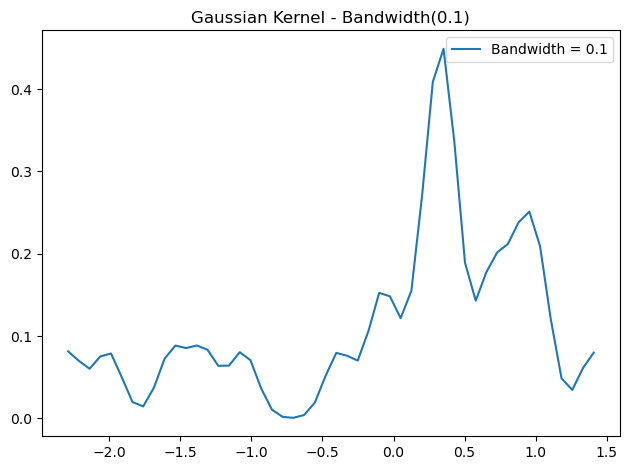

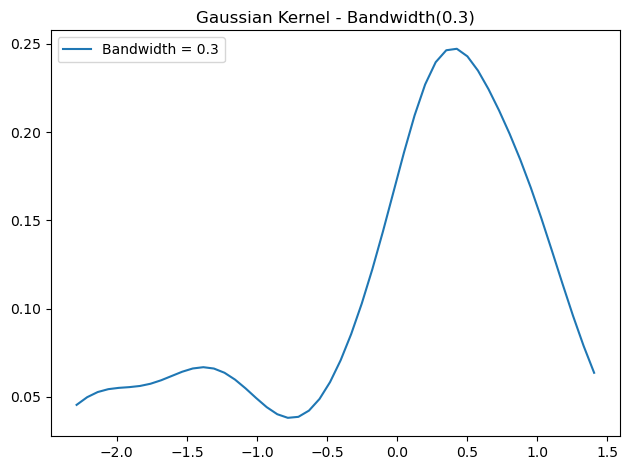

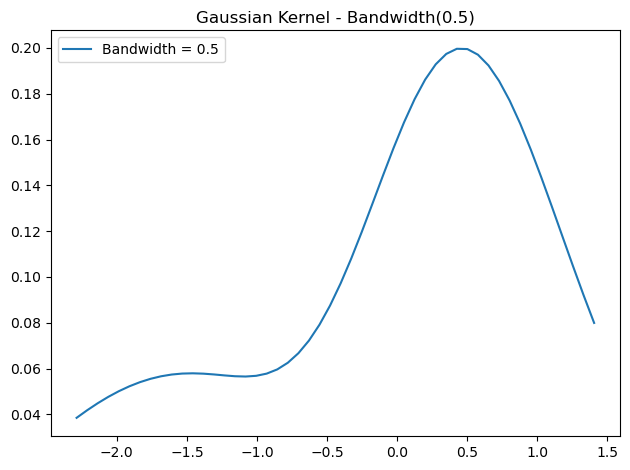

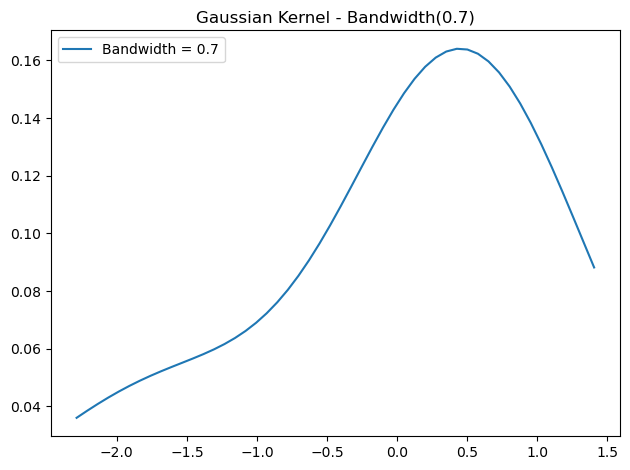

In [201]:
x = np.linspace(np.amin(grades_normalized), np.amax(grades_normalized), 50)

(xx,) = np.meshgrid(x)

X_1d = xx.ravel()
gaussianZZs = []

for h in bandwidths:

    print("Bandwidth :", h)

    probs = KDE1D(grades_normalized, h, X_1d, 1, "gaussian")

    zz = np.array(probs)

    gaussianZZs.append(zz)

for i, bandwidth in enumerate(bandwidths):
    fig, ax = plt.subplots(1)

    ax.plot(xx, gaussianZZs[i], label="Bandwidth = {}".format(bandwidth))

    ax.legend()
    ax.set_title("Gaussian Kernel - Bandwidth(" + str(bandwidth) + ")")
    fig.tight_layout()

plt.show()

### 2D Synthetic Gaussians Dataset

Bandwidth : 0.1
Bandwidth : 0.3
Bandwidth : 0.5
Bandwidth : 0.7


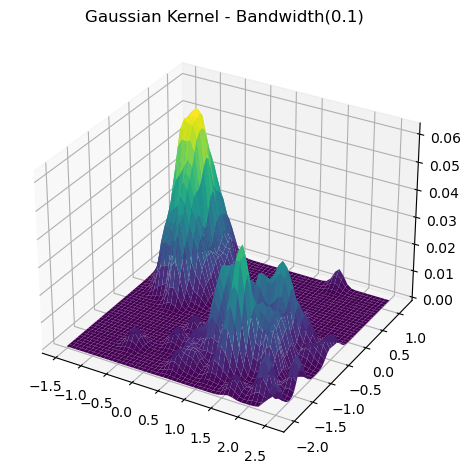

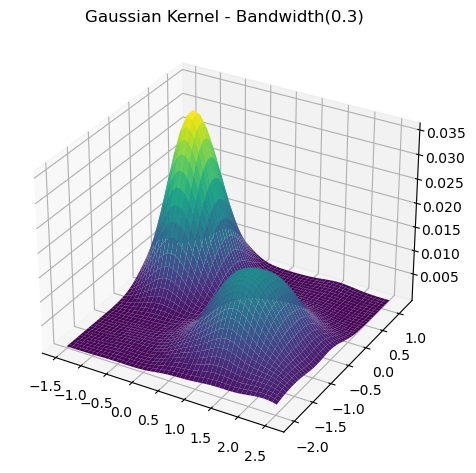

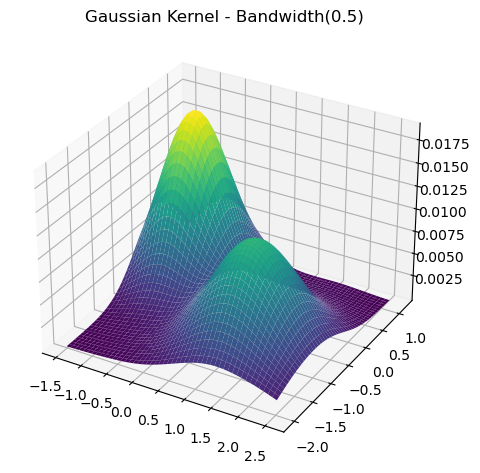

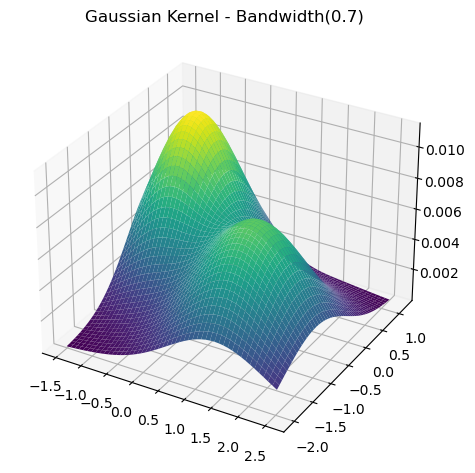

In [202]:
x = np.linspace(
    np.amin(synthetic_normalized[:, 0]), np.amax(synthetic_normalized[:, 0]), 50
).reshape(-1, 1)
y = np.linspace(
    np.amin(synthetic_normalized[:, 1]), np.amax(synthetic_normalized[:, 1]), 50
).reshape(-1, 1)
xx, yy = np.meshgrid(x, y)
X_2d = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
gaussianZZs = []

for h in bandwidths:
    print("Bandwidth :", h)

    probs = KDE(synthetic_normalized, h, X_2d, 1, "gaussian")

    zz = np.array(probs).reshape(xx.shape)

    gaussianZZs.append(zz)

j = -1
for i in range(len(gaussianZZs)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.plot_surface(xx, yy, gaussianZZs[i], cmap="viridis")
    ax.set_title(f"Gaussian Kernel - Bandwidth({bandwidths[i]})")
    fig.tight_layout()

# 3.3 K-Nearest Neighbours

In [37]:
def euclidean_distance(p, q):
    return np.sqrt(np.sum((np.array(p) - np.array(q)) ** 2))


def KNN(data_points, x, k):
    m = len(data_points)
    d = len(data_points[0])
    probs = []

    for x_1 in x:
        distances = np.sqrt(np.sum((data_points - x_1) ** 2, axis=1))
        r_x = np.sort(distances)[k - 1]

        if r_x == 0:
            p_x = 1
        elif d == 1:
            p_x = k / (m * 2 * r_x)
        elif d == 2:
            p_x = k / (m * np.pi * r_x**2)
        probs.append(p_x)

    return probs

### 1D Grades Dataset

k:  1
k:  3
k:  5
k:  7
End KNN


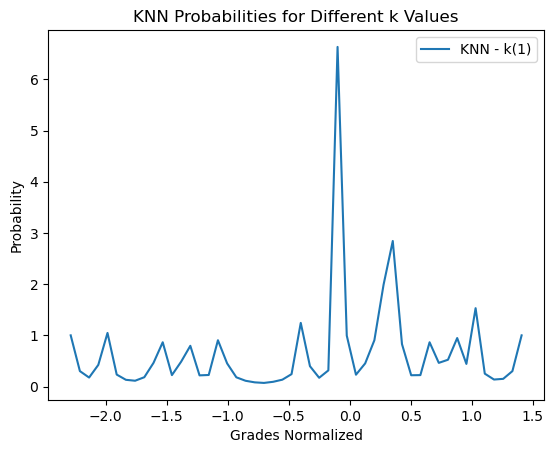

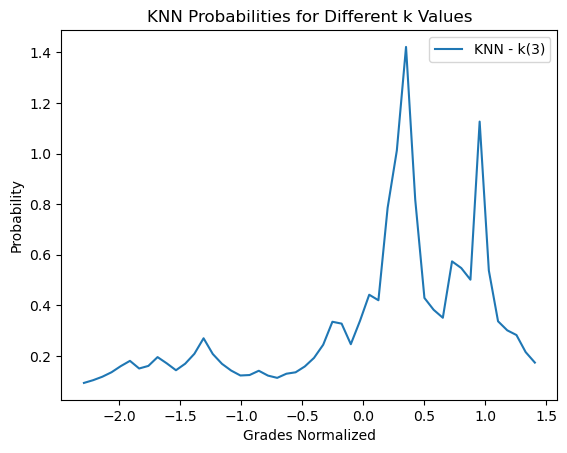

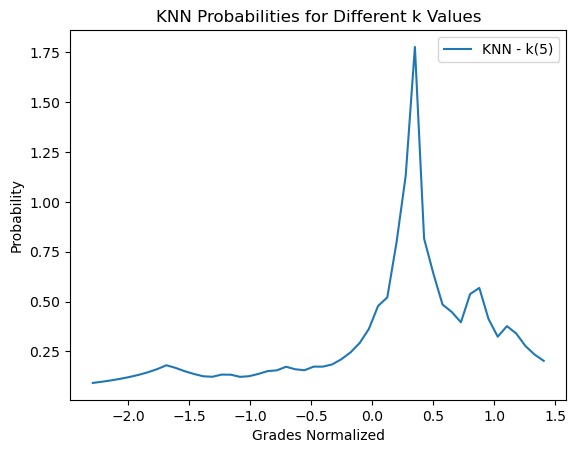

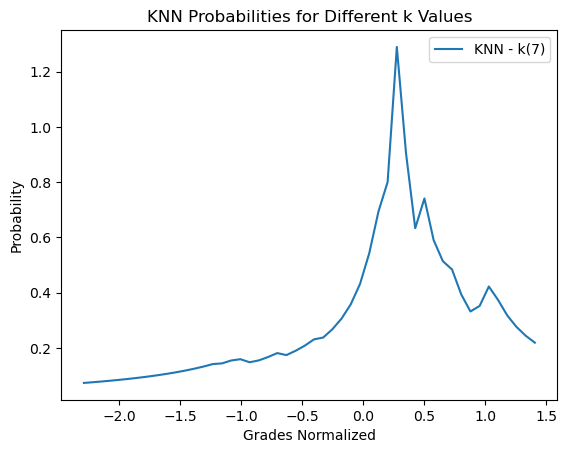

In [38]:
Ks = [1, 3, 5, 7]
x = np.linspace(np.amin(grades_normalized), np.amax(grades_normalized), 50)
(xx,) = np.meshgrid(x)

X_1d = xx.ravel()
probability = []

for k in Ks:
    print("k: ", k)

    probs = KNN(grades_normalized, X_1d, k)

    zz = np.array(probs)

    probability.append(zz)


print("End KNN")
for i, k in enumerate(Ks):
    plt.plot(X_1d, probability[i], label="KNN - k(" + str(k) + ")")

    plt.xlabel("Grades Normalized")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("KNN Probabilities for Different k Values")
    plt.show()

### 2D Synthetic Gaussians Dataset

(10000, 2)
k:  5
k:  50
k:  100
k:  200
End KNN


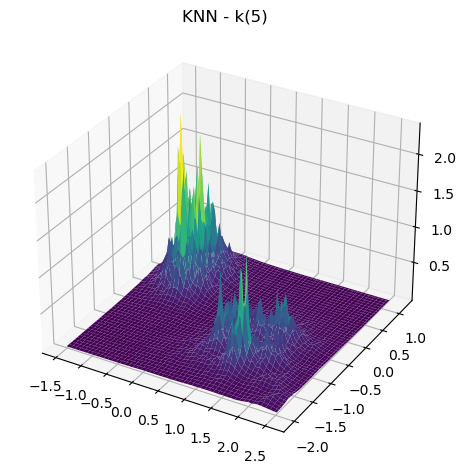

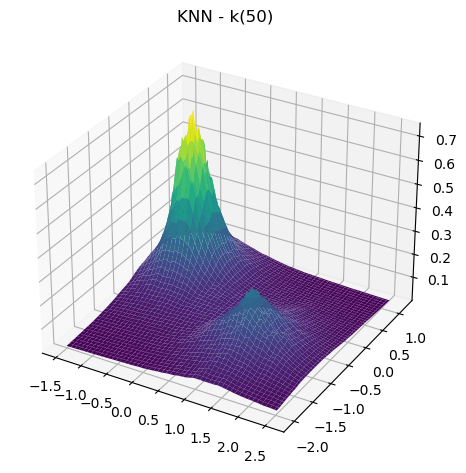

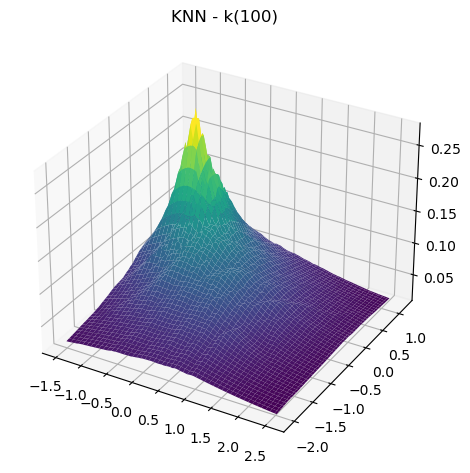

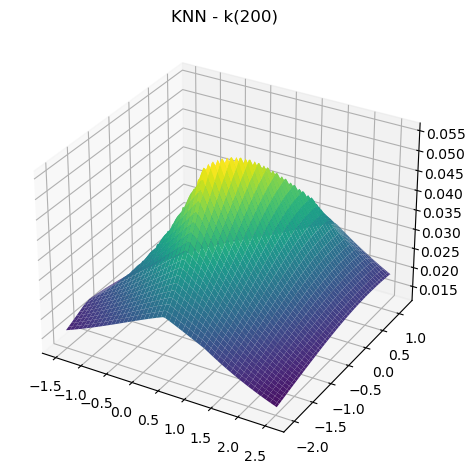

In [59]:
Ks = [5, 50, 100, 200]
x = np.linspace(
    np.amin(synthetic_normalized[:, 0]), np.amax(synthetic_normalized[:, 0]), 100
).reshape(-1, 1)
y = np.linspace(
    np.amin(synthetic_normalized[:, 1]), np.amax(synthetic_normalized[:, 1]), 100
).reshape(-1, 1)

xx, yy = np.meshgrid(x, y)

X_2d = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
probability = []


for k in Ks:
    print("k: ", k)

    probs = KNN(synthetic_normalized, X_2d, k)

    zz = np.array(probs).reshape(xx.shape)

    probability.append(zz)

print("End KNN")

for i in range(len(Ks)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.plot_surface(xx, yy, probability[i], cmap="viridis")
    ax.set_title("KNN - k(" + str(Ks[i]) + ")")
    fig.tight_layout()